In [257]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

random.seed = 42
np.random.seed(1024)

### Load Titanic dataset and select a subset of features, then split it to train/test (70/30) 

In [258]:
titanic = pd.read_csv('titanic.csv', sep=',', skip_blank_lines=True, index_col=False)
titanic_imp = pd.read_csv('titanic.csv', sep=',', skip_blank_lines=True, index_col=False)

labelenc = LabelEncoder()

X = titanic[["Survived", "Age", "Sex", "Fare", "Embarked", "SibSp", "Parch"]]

mean_age = X["Age"].mean()
X.loc[:, "Age"] = X.loc[:, "Age"].fillna(mean_age)

X.loc[:, "Embarked"] = labelenc.fit_transform(X.loc[:, "Embarked"].values)
X.loc[:, "Sex"] = labelenc.fit_transform(X.loc[:, "Sex"].values)

y = X.iloc[:, 0].values
X = X.drop(columns="Survived").values

X_imp = titanic_imp[["Age", "Sex", "Fare", "Embarked", "SibSp", "Parch"]]

X_imp.loc[:, "Embarked"] = labelenc.fit_transform(X_imp.loc[:, "Embarked"].values)
X_imp.loc[:, "Sex"] = labelenc.fit_transform(X_imp.loc[:, "Sex"].values)

X_imp = X_imp.values
y_imp = titanic_imp.iloc[:, 1].values
 
x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=.7,random_state=42)
x_train_imp, x_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp,y_imp,train_size=.7, random_state=42)


/home/panos/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Scaling

In [259]:
scaler, scaler_imp = MinMaxScaler(feature_range=(0,3)), MinMaxScaler(feature_range=(0,3))

scaler = scaler.fit(x_train)
scaler_imp = scaler_imp.fit(x_train_imp)

x_train_norm, x_test_norm = scaler.transform(x_train), scaler.transform(x_test)
x_train_imp_norm, x_test_imp_norm = scaler_imp.transform(x_train_imp), scaler_imp.transform(x_test_imp)

### Use sklearn's imputer to predict missing values of 'Age'  

In [260]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputer = imputer.fit(x_train_imp_norm)

x_train_imp_norm_transformed = imputer.transform(x_train_imp_norm)
x_test_imp_norm_transformed = imputer.transform(x_test_imp_norm)


### Define two methods(for the default dataset and the one where we imputed missing values) to train the model and find the k-value with the highest F1 Score

In [261]:
def evaluate_model(weight, p):
  best_f1_score, best_nn = float('-inf'), 0
  weights_, p_ = weight, p
  f1_scores = []
  y_pred = None

  for n in range(1,201):
    model = KNeighborsClassifier(n, weights=weights_, p=p_, metric='minkowski')
    model = model.fit(x_train_norm, y_train)
    y_predicted = model.predict(x_test)
    f1_score = metrics.f1_score(y_test, y_predicted)
    f1_scores += [f1_score]
    
    if f1_score > best_f1_score:
      best_f1_score, best_nn = f1_score, n
      y_pred = y_predicted
  
  print(f"Best F1 Score : {np.round(best_f1_score*100, 5)}% for {best_nn} nearest neighbor(s)")

  return f1_scores, y_pred


def evaluate_imputed_model(weight, p):
  best_f1_score, best_nn = float('-inf'), 0
  weights_, p_ = weight, p
  f1_scores = []
  y_pred = None

  for n in range(1,201):
    model = KNeighborsClassifier(n, weights=weights_, p=p_, metric='minkowski')
    model = model.fit(x_train_imp_norm_transformed, y_train_imp)
    y_predicted = model.predict(x_test_imp_norm_transformed)
    f1_score = metrics.f1_score(y_test_imp, y_predicted)
    f1_scores += [f1_score]
    
    if f1_score > best_f1_score:
      best_f1_score, best_nn = f1_score, n
      y_pred = y_predicted

  print(f"[Imputed Values] Best F1 Score : {np.round(best_f1_score*100, 5)}% for {best_nn} nearest neighbor(s)")

  return f1_scores, y_pred

In [262]:
def show_stats(y_test_, y_pred):
  print("=" * 18)  
  print("Accuracy: %7.3f%%" %(metrics.accuracy_score(y_test_, y_pred) * 100))
  print("Precision: %5.3f%%" %(metrics.precision_score(y_test_, y_pred) * 100))
  print("Recall: %9.3f%%" %(metrics.recall_score(y_test_, y_pred) * 100))
  print("F1 Score: %7.3f%%" %(metrics.f1_score(y_test_, y_pred) * 100))

model = KNeighborsClassifier(15, weights='uniform', p=2, metric='minkowski')
model = model.fit(x_train_norm, y_train)
y_predicted = model.predict(x_test)

show_stats(y_test, y_predicted)

Accuracy:  69.776%
Precision: 59.375%
Recall:    85.586%
F1 Score:  70.111%


# Find the optimal value for the nearest neighbors based on the F1 score and print stats  

#### Uniform weights w/ p = 2

In [263]:
f1_scores_uniform_p2, y_predicted_uniform_p2 = evaluate_model('uniform', 2)
show_stats(y_test, y_predicted_uniform_p2)

f1_scores_uniform_p2_imp, y_predicted_uniform_p2_imp = evaluate_imputed_model('uniform', 2)
show_stats(y_test_imp, y_predicted_uniform_p2_imp)

Best F1 Score : 73.77049% for 52 nearest neighbor(s)
Accuracy:  76.119%
Precision: 67.669%
Recall:    81.081%
F1 Score:  73.770%
[Imputed Values] Best F1 Score : 76.92308% for 13 nearest neighbor(s)
Accuracy:  82.090%
Precision: 82.474%
Recall:    72.072%
F1 Score:  76.923%


#### Distance weighing w/ p = 2

In [264]:
f1_scores_distance_p2, y_predicted_distance_p2 = evaluate_model('distance', 2)
show_stats(y_test, y_predicted_distance_p2)

f1_scores_distance_p2_imp, y_predicted_distance_p2_imp = evaluate_imputed_model('distance', 2)
show_stats(y_test_imp, y_predicted_distance_p2_imp)

Best F1 Score : 74.80916% for 52 nearest neighbor(s)
Accuracy:  75.373%
Precision: 64.901%
Recall:    88.288%
F1 Score:  74.809%
[Imputed Values] Best F1 Score : 73.14815% for 10 nearest neighbor(s)
Accuracy:  78.358%
Precision: 75.238%
Recall:    71.171%
F1 Score:  73.148%


#### Uniform weights w/ p = 1

In [265]:
f1_scores_uniform_p1, y_predicted_uniform_p1 = evaluate_model('uniform', 1)
show_stats(y_test, y_predicted_uniform_p1)

f1_scores_uniform_p1_imp, y_predicted_uniform_p1_imp = evaluate_imputed_model('uniform', 1)
show_stats(y_test_imp, y_predicted_uniform_p1_imp)

Best F1 Score : 68.93939% for 200 nearest neighbor(s)
Accuracy:  69.403%
Precision: 59.477%
Recall:    81.982%
F1 Score:  68.939%
[Imputed Values] Best F1 Score : 77.14286% for 22 nearest neighbor(s)
Accuracy:  82.090%
Precision: 81.818%
Recall:    72.973%
F1 Score:  77.143%


#### Distance weighing w/ p = 1

In [266]:
f1_scores_distance_p1, y_predicted_distance_p1 = evaluate_model('distance', 1)
show_stats(y_test, y_predicted_distance_p1)

f1_scores_distance_p1_imp, y_predicted_distance_p1_imp = evaluate_imputed_model('distance', 1)
show_stats(y_test_imp, y_predicted_distance_p1_imp)

Best F1 Score : 67.88321% for 195 nearest neighbor(s)
Accuracy:  67.164%
Precision: 57.055%
Recall:    83.784%
F1 Score:  67.883%
[Imputed Values] Best F1 Score : 75.45455% for 9 nearest neighbor(s)
Accuracy:  79.851%
Precision: 76.147%
Recall:    74.775%
F1 Score:  75.455%


#### Uniform weights w/ p = 4

In [267]:
f1_scores_uniform_p4, y_predicted_uniform_p4 = evaluate_model('uniform', 4)
show_stats(y_test, y_predicted_uniform_p4)

f1_scores_uniform_p4_imp, y_predicted_uniform_p4_imp = evaluate_imputed_model('uniform', 4)
show_stats(y_test_imp, y_predicted_uniform_p4_imp)

Best F1 Score : 68.49315% for 15 nearest neighbor(s)
Accuracy:  74.254%
Precision: 69.444%
Recall:    67.568%
F1 Score:  68.493%
[Imputed Values] Best F1 Score : 77.88462% for 11 nearest neighbor(s)
Accuracy:  82.836%
Precision: 83.505%
Recall:    72.973%
F1 Score:  77.885%


#### Distance weighing w/ p = 4

In [268]:
f1_scores_distance_p4, y_predicted_distance_p4 = evaluate_model('distance', 4)
show_stats(y_test, y_predicted_distance_p4)

f1_scores_distance_p4_imp, y_predicted_distance_p4_imp = evaluate_imputed_model('distance', 4)
show_stats(y_test_imp, y_predicted_distance_p4_imp)

Best F1 Score : 68.49315% for 15 nearest neighbor(s)
Accuracy:  74.254%
Precision: 69.444%
Recall:    67.568%
F1 Score:  68.493%
[Imputed Values] Best F1 Score : 73.23944% for 29 nearest neighbor(s)
Accuracy:  78.731%
Precision: 76.471%
Recall:    70.270%
F1 Score:  73.239%


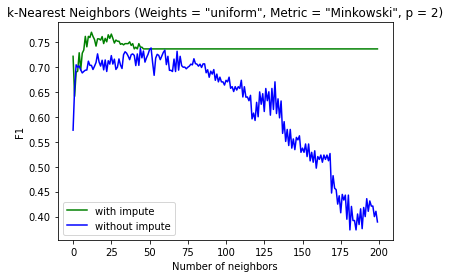

In [269]:
plt.title('k-Nearest Neighbors (Weights = "uniform", Metric = "Minkowski", p = 2)')
plt.plot(f1_scores_uniform_p2_imp, 'g', label='with impute')
plt.plot(f1_scores_uniform_p2, '-b', label='without impute')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('F1')
plt.show()